In [1]:
import pandas as pd

ad_clicks = pd.read_csv(r'C:\Users\Pedram\Documents\GitHub\Ad_Clicks___AB_Testing\ad_clicks.txt')

def display_as_percentage(val):
  return '{:.1}%'.format(val * 100)


In [8]:
import numpy as np
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import math
import statistics

## Examining the First Few Rows of ad_clicks

In [45]:
ad_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654 entries, 0 to 1653
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             1654 non-null   object
 1   utm_source          1654 non-null   object
 2   day                 1654 non-null   object
 3   ad_click_timestamp  565 non-null    object
 4   experimental_group  1654 non-null   object
 5   is_click            1654 non-null   bool  
dtypes: bool(1), object(5)
memory usage: 66.3+ KB


In [47]:
# Overview of unique values in teh dataframe
print(ad_clicks.nunique())

user_id               1654
utm_source               4
day                      7
ad_click_timestamp     464
experimental_group       2
is_click                 2
dtype: int64


In [2]:
print(ad_clicks.head(5))

                                user_id utm_source           day  \
0  008b7c6c-7272-471e-b90e-930d548bd8d7     google  6 - Saturday   
1  009abb94-5e14-4b6c-bb1c-4f4df7aa7557   facebook    7 - Sunday   
2  00f5d532-ed58-4570-b6d2-768df5f41aed    twitter   2 - Tuesday   
3  011adc64-0f44-4fd9-a0bb-f1506d2ad439     google   2 - Tuesday   
4  012137e6-7ae7-4649-af68-205b4702169c   facebook    7 - Sunday   

  ad_click_timestamp experimental_group  
0               7:18                  A  
1                NaN                  B  
2                NaN                  A  
3                NaN                  B  
4                NaN                  B  


##  Which Ad Platform is Getting the Company the Most Views?
How many views (i.e., rows of the table) came from each 'utm_source'?

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


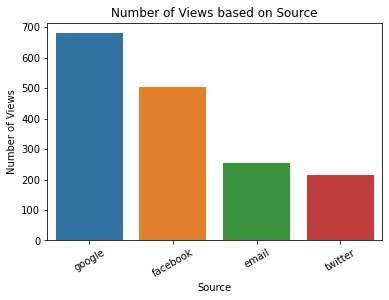

In [33]:
# A bar plot to check the 'utm_source' values
sns.countplot(ad_clicks['utm_source'], order = ad_clicks['utm_source'].value_counts().index)
plt.title('Number of Views based on Source')
plt.xlabel('Source')
plt.ylabel('Number of Views')
plt.xticks(rotation=30) #rotate your labels along the x-axis to make sure they are visible. For it to work, be sure to call .countplot() above it.
plt.show()

In [6]:
ad_clicks\
    .groupby('utm_source')\
    .user_id.count()\
    .reset_index()

,utm_source,user_id
0,email,255
1,facebook,504
2,google,680
3,twitter,215


## Create New Column called 'is_click'
If the column ad_click_timestamp is not null, then someone actually clicked on the ad that was displayed.
Create a new column called 'is_click', which is True if 'ad_click_timestamp' is not null and False otherwise.
 

In [28]:
ad_clicks['is_click'] = ad_clicks\
    .ad_click_timestamp\
    .notnull()
print(ad_clicks.head())

                                user_id utm_source           day  \
0  008b7c6c-7272-471e-b90e-930d548bd8d7     google  6 - Saturday   
1  009abb94-5e14-4b6c-bb1c-4f4df7aa7557   facebook    7 - Sunday   
2  00f5d532-ed58-4570-b6d2-768df5f41aed    twitter   2 - Tuesday   
3  011adc64-0f44-4fd9-a0bb-f1506d2ad439     google   2 - Tuesday   
4  012137e6-7ae7-4649-af68-205b4702169c   facebook    7 - Sunday   

  ad_click_timestamp experimental_group  is_click  
0               7:18                  A      True  
1                NaN                  B     False  
2                NaN                  A     False  
3                NaN                  B     False  
4                NaN                  B     False  


## Percentage of People who Clicked on ads from Each Source
The objective is to determine the percentage of individuals who clicked on ads for each utm_source. To achieve this, we will begin by grouping the data based on utm_source and is_click, then calculate the count of user_id's in each group. The resulting outcome will be stored in the variable called "clicks_by_source."

In [30]:
clicks_by_source = ad_clicks\
  .groupby(['utm_source', 'is_click'])\
  .user_id.count()\
  .reset_index()
 
print(clicks_by_source)

  utm_source  is_click  user_id
0      email     False      175
1      email      True       80
2   facebook     False      324
3   facebook      True      180
4     google     False      441
5     google      True      239
6    twitter     False      149
7    twitter      True       66


## Create Clicks Pivot Table 
The data will be pivoted, having "is_click" as columns (either True or False), "utm_source" as the index, and "user_id" as the values. The resulting pivot table will be saved in the variable named "clicks_pivot."

In [31]:
clicks_pivot = clicks_by_source\
  .pivot(
   columns='is_click',
   index='utm_source',
   values='user_id'
  ).reset_index()
print(clicks_pivot)

is_click utm_source  False  True
0             email    175    80
1          facebook    324   180
2            google    441   239
3           twitter    149    66


## Adding Percent Clicked Column in Clicks Pivot Table
A new column called "percent_clicked" will be created in clicks_pivot, representing the percentage of users who clicked on the ad from each utm_source. 
The click rates for each source will be compared to determine if there was any difference.


In [42]:
clicks_pivot['percent_clicked'] = clicks_pivot[True] /(clicks_pivot[True] + 
clicks_pivot[False])
print(clicks_pivot)

is_click utm_source  False  True  percent_clicked
0             email    175    80         0.313725
1          facebook    324   180         0.357143
2            google    441   239         0.351471
3           twitter    149    66         0.306977


In [51]:
# Sort the df by 'percent_clicked' in ascending order
clicks_pivot_sorted = clicks_pivot.sort_values(by='percent_clicked')

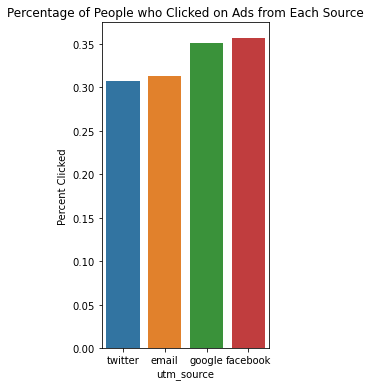

<Figure size 432x288 with 0 Axes>

In [62]:
plt.figure(figsize=(3, 6))
sns.barplot(x='utm_source', y='percent_clicked', data=clicks_pivot_sorted)

# Set labels and title
plt.xlabel('utm_source')
plt.ylabel('Percent Clicked')
plt.title('Percentage of People who Clicked on Ads from Each Source')
plt.show()
plt.clf()

As can be observed in this bar plot, in general, the ad on Facebook showed a higher conversion rate compared to other utm sources in this marketing campaign.

## Number of People Showed Each Ad
Ad A or Ad B was shown to the users based on the "experimental_group" column.
It is evident that both ads had been exposed to an equal number of audiences.

In [43]:
print(ad_clicks\
  .groupby('experimental_group').user_id\
  .count()\
  .reset_index()
)

  experimental_group  user_id
0                  A      827
1                  B      827


## Number of Users that Clicked on Each Ad
Using the column is_click that we defined earlier, check to see if a greater percentage of users clicked on Ad A or Ad B.

In [44]:
ad_clicks_pivot = ad_clicks\
  .groupby(['experimental_group', 'is_click']).user_id\
  .count()\
  .reset_index()\
  .pivot(
    index = 'experimental_group',
    columns = 'is_click',
    values = 'user_id'
  )\
  .reset_index()

ad_clicks_pivot['percent_clicked']= ad_clicks_pivot[True]\
    /(ad_clicks_pivot[True] + ad_clicks_pivot[False]) 
print(ad_clicks_pivot)

is_click experimental_group  False  True  percent_clicked
0                         A    517   310         0.374849
1                         B    572   255         0.308343


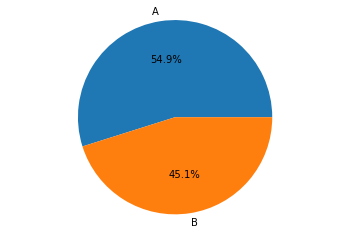

<Figure size 432x288 with 0 Axes>

In [64]:
# A pie chart for comparison
wedge_sizes = ad_clicks_pivot.percent_clicked
wedge_labels = ad_clicks_pivot.experimental_group

plt.pie(wedge_sizes, labels = wedge_labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()
plt.clf()

It is evident that in this experiment, in general, 'A' had a higher performance in case of click percentage. 

## Does the Number of Clicks on Each Ad Change Throughout the Week? ##
Start by creating two DataFrames: a_clicks and b_clicks, which contain only the results for A group and B group, respectively.

In [68]:
a_clicks = ad_clicks[ad_clicks.experimental_group == 'A']
b_clicks = ad_clicks[ad_clicks.experimental_group == 'B']

In [69]:
print(a_clicks.head())

                                user_id utm_source            day  \
0  008b7c6c-7272-471e-b90e-930d548bd8d7     google   6 - Saturday   
2  00f5d532-ed58-4570-b6d2-768df5f41aed    twitter    2 - Tuesday   
5  013b0072-7b72-40e7-b698-98b4d0c9967f   facebook     1 - Monday   
6  0153d85b-7660-4c39-92eb-1e1acd023280     google   4 - Thursday   
7  01555297-d6e6-49ae-aeba-1b196fdbb09f     google  3 - Wednesday   

  ad_click_timestamp experimental_group  is_click  
0               7:18                  A      True  
2                NaN                  A     False  
5                NaN                  A     False  
6                NaN                  A     False  
7                NaN                  A     False  


## Percentage of Users Who Clicked on the Ad by Day
For each group (a_clicks and b_clicks), calculate the percent of users who clicked on the ad by day.


## Ad A:

In [79]:
a_clicks_pivot = a_clicks\
.groupby(['is_click', 'day']).user_id\
.count()\
.reset_index()\
.pivot(
  index = 'day',
  columns = 'is_click',
  values = 'user_id'
)\
.reset_index()\
 
a_clicks_pivot['percent_clicked'] = a_clicks_pivot[True] / (a_clicks_pivot[True] + a_clicks_pivot[False]) 
 
print(a_clicks_pivot)

is_click            day  False  True  percent_clicked
0            1 - Monday     70    43         0.380531
1           2 - Tuesday     76    43         0.361345
2         3 - Wednesday     86    38         0.306452
3          4 - Thursday     69    47         0.405172
4            5 - Friday     77    51         0.398438
5          6 - Saturday     73    45         0.381356
6            7 - Sunday     66    43         0.394495


## Ad B:

In [85]:
b_clicks_pivot = b_clicks\
  .groupby(['is_click', 'day']).user_id\
  .count()\
  .reset_index()\
  .pivot(
    index = 'day',
    columns = 'is_click',
    values = 'user_id'
  )\
  .reset_index()
 
b_clicks_pivot['percent_clicked'] = b_clicks_pivot[True] / (b_clicks_pivot[True] + b_clicks_pivot[False])
 
print(b_clicks_pivot)


is_click            day  False  True  percent_clicked
0            1 - Monday     81    32         0.283186
1           2 - Tuesday     74    45         0.378151
2         3 - Wednesday     89    35         0.282258
3          4 - Thursday     87    29         0.250000
4            5 - Friday     90    38         0.296875
5          6 - Saturday     76    42         0.355932
6            7 - Sunday     75    34         0.311927


In [86]:
total_clicks_day = pd.DataFrame()
total_clicks_day['day'] = a_clicks_pivot.day
total_clicks_day['A'] = a_clicks_pivot.percent_clicked
total_clicks_day['B'] = b_clicks_pivot.percent_clicked
print(total_clicks_day)

             day         A         B
0     1 - Monday  0.380531  0.283186
1    2 - Tuesday  0.361345  0.378151
2  3 - Wednesday  0.306452  0.282258
3   4 - Thursday  0.405172  0.250000
4     5 - Friday  0.398438  0.296875
5   6 - Saturday  0.381356  0.355932
6     7 - Sunday  0.394495  0.311927


# Hypothesis Testing

At this stage, it is desired to ensure that the difference between the conversion rates of A and B is not accidental and holds statistical significance for the conculsion.

For this experiment, the "Two-Sample T-test" has been chosen as the appropriate statistical test due to its ability to compare the two independent groups (Ad A and Ad B) and assess them statistically.

## Define Null and Alternative Hypothesis
###    H0: There is no difference in the conversion rates of Ad A and Ad B.
###    H1: Ad A has a better conversion rate compared to Ad B. 

Following the rule of thumb in scientific research, a significance level (alpha) of 0.05 is considered for conducting this hypothesis testing.



In [107]:
import scipy.stats as stats

# Put the conversion rate data for Ad A and Ad B in separate objects
conversion_rate_ad_a = total_clicks_day.A
conversion_rate_ad_b = total_clicks_day.B

# Perform the Two-Sample T-test
t_statistic, p_value = stats.ttest_ind(conversion_rate_ad_a, conversion_rate_ad_b)

# Check the p-value to determine statistical significance
print('P-value is :', p_value)

if p_value < 0.05:
    print("Ad A has a significantly better conversion rate than Ad B.")
else:
    print("There is no significant difference in the conversion rates of Ad A and Ad B.")


P-value is : 0.008064141433970693
Ad A has a significantly better conversion rate than Ad B.


The DataFrame is being transposed then to prepare a visual representation of the conclusion of this experiment.

In [90]:
# Melt the DataFrame to transform the columns 'A' and 'B' into rows under the 'experiment' column
transposed_df = pd.melt(total_clicks_day, id_vars=['day'], var_name='experiment', value_name='percent_clicked')

# Display the transposed DataFrame
print(transposed_df)

              day experiment  percent_clicked
0      1 - Monday          A         0.380531
1     2 - Tuesday          A         0.361345
2   3 - Wednesday          A         0.306452
3    4 - Thursday          A         0.405172
4      5 - Friday          A         0.398438
5    6 - Saturday          A         0.381356
6      7 - Sunday          A         0.394495
7      1 - Monday          B         0.283186
8     2 - Tuesday          B         0.378151
9   3 - Wednesday          B         0.282258
10   4 - Thursday          B         0.250000
11     5 - Friday          B         0.296875
12   6 - Saturday          B         0.355932
13     7 - Sunday          B         0.311927


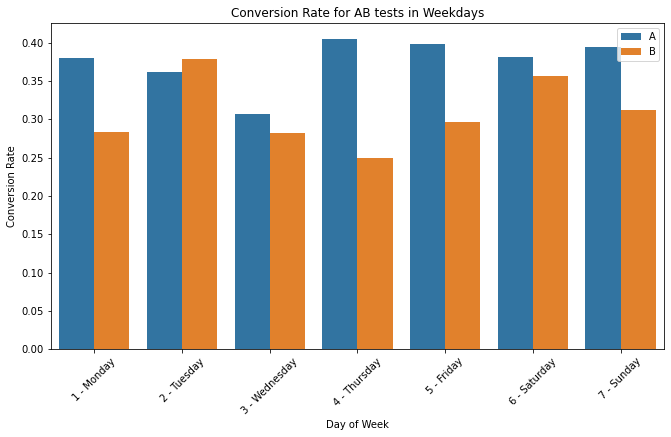

<Figure size 432x288 with 0 Axes>

In [105]:
plt.figure(figsize=(11,6))
sns.barplot(x = 'day', y = 'percent_clicked', hue = 'experiment', data = transposed_df)
plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate for AB tests in Weekdays')
plt.legend(loc='upper right')
plt.show()
plt.clf()

## Conclusion

According to our analysis and the visual representation of the plot, it is statistically significant and evident that users clicked on Ad A more frequently compared to Ad B on almost every day of the week, with the exception of Tuesday. In other words, Ad A received a higher number of clicks than Ad B throughout the majority of the week, indicating a stronger user engagement with Ad A in the marketing campaign. 